##**1. Use Case:** **User Adoption Analysis**


A client has data on users for an application from the past two years. They define an "adopted user" as a user who has logged into the application on three separate days in at least one seven ­day period. They want to understand what variables contribute to a user converting into an adopted user. The assignment is to inspect the data and prepare an analysis that shows non-technical stakeholders what variables and conditions are associated with user adoption.
<BR><BR>
**Data Overview** <BR>                     
The data is available as two attached CSV files:                                                                  

●       takehome_user_engagement.csv                                                      

●       takehome_users.csv
<BR>
The data has the following two tables:                                                          

A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:                                                                      
●  name: the user's name     
●  object_id: the user's id                                                     
●  email: email address                                             
●  creation_source: how their account was created. This takes on one of 5 values:

            ○  PERSONAL_PROJECTS: invited to join another user's personal workspace
            ○  GUEST_INVITE: invited to an organization as a guest (limited permissions)
            ○  ORG_INVITE: invited to an organization (as a full member)
            ○  SIGNUP: signed up via the website
            ○  SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)                                                                              
●  creation_time: when they created their account                                                             
●  last_session_creation_time: unix timestamp of last login                                             
●  opted_in_to_mailing_list: whether they have opted into receiving marketing emails
●  enabled_for_marketing_drip: whether they are on the regular marketing email drip       
●  org_id: the organization (group of users) they belong to                                     
●  invited_by_user_id: which user invited them to join (if applicable)<BR>
A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.<BR><BR>
**Instructions**<BR>
Defining an "adopted user" as a user who has logged into the application on
three separate days in at least one seven ­day period, identify which factors predict future user adoption. Arriving at an answer may look something like this:
<BR>
* Merge, clean, and organize data as necessary<BR>
* Define a transformation to evaluate which users are adopted users along with other feature engineering<BR>
* Conduct exploratory data analysis<BR>
* If necessary, develop a machine-learning model<BR>
* Produce a report with findings about the influence of different variables with respect to adopted users.<BR>

## **2. Importing Dependancies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
!pip install shap
import shap

In [ ]:
!pip install joblib
import joblib

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## **3. Importing Dataset, Data Inspection**

#### **users**

**Inspecting users data**

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/TensorIOT Assignment/takehome_users.csv', encoding='latin1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
users.info() # Get information about the DataFrame, including missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


**Counting missing values from features last_session_creation_time and invited_by_user_id**

In [ ]:
last_session_creation_time_missingCount = len(users) - len([x for x in list(users.last_session_creation_time) if not isinstance(x, float) or not math.isnan(x)])
print(f"Missing Values Count from Feature last_session_creation_time :{last_session_creation_time_missingCount}")

Missing Values Count from Feature last_session_creation_time :3177


In [ ]:
invited_by_user_id_missingCount = len(users) - len([x for x in list(users.invited_by_user_id) if not isinstance(x, float) or not math.isnan(x)])
invited_by_user_id_missingCount
print(f"Missing Values Count from Feature invited_by_user_id :{invited_by_user_id_missingCount}")

Missing Values Count from Feature invited_by_user_id :5583


**Observations:**
1. Dataset have 12,000 entries across 10 features and it contains both numerical, categorical / texual  and time related features.
    * **Numerical Features:** `object_id`, `opted_in_to_mailing_list`, `enabled_for_marketing_drip`, `org_id` - These columns seem to contain numerical data.
    * **categorical or textual Features:** creation_time, name, email, creation_source - These columns are likely categorical or textual.
    * **Time-related Columns:** `creation_time` and `last_session_creation_time` are time-related fields, but the `creation_time` seems to be stored as an object  while the latter is stored as a float. We might have to convert these to datetime format for further processing and feature engineering.
2. Missing Values:
    * **`last_session_creation_time`** has a considerable number of missing values (around 3,177 entries). **Imputation or handling of missing values** might be necessary for analysis involving this column.
    * **`invited_by_user_id`** also has missing values (5,583 entries), indicating instances where users were not invited by another user or the data was not recorded.
3. **User Engagement Metrics:**
    * **`opted_in_to_mailing_list`** and **`enabled_for_marketing_drip`** are binary flags, likely indicating whether a user has opted into these services.


####**users_engagement**


**Inspecting user engagement**

In [ ]:
engagement = pd.read_csv('/content/drive/MyDrive/TensorIOT Assignment/takehome_user_engagement.csv', encoding='latin1')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [ ]:
engagement.info()  # Get information about the DataFrame, including missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [ ]:
engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

**Observations:**
1. Dataset contains 207,917 entries across 3 columns with **No Missing Values**
2. Converting **`time_stamp`** to datetime format will be required for further analysis.
3. Feature **`visited`** could be useful to know user behaviour and engagement.

## **4. Exploratory Data Analysis**

#### **Univariate Analysis**

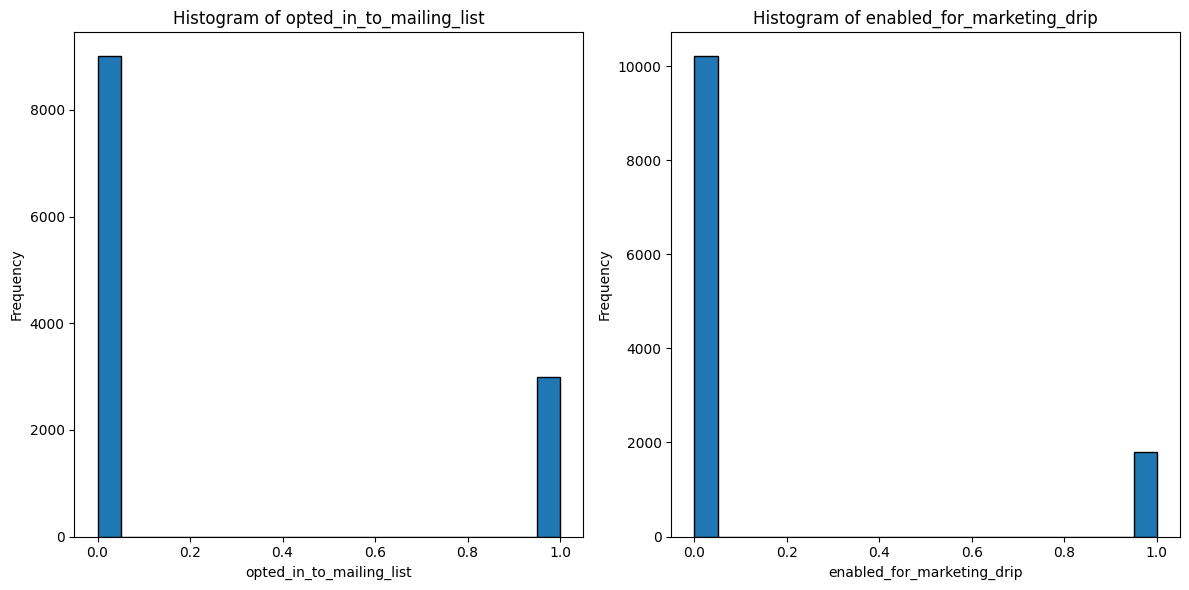

Summary Statistics for Numerical Columns:
       opted_in_to_mailing_list  enabled_for_marketing_drip
count              12000.000000                12000.000000
mean                   0.249500                    0.149333
std                    0.432742                    0.356432
min                    0.000000                    0.000000
25%                    0.000000                    0.000000
50%                    0.000000                    0.000000
75%                    0.000000                    0.000000
max                    1.000000                    1.000000


In [ ]:
import matplotlib.pyplot as plt

# Numerical Columns (excluding 'org_id')
numerical_columns = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']

# Summary Statistics
numerical_summary = users[numerical_columns].describe()

# Create a 1x2 grid for histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot histograms in a 1x2 grid
for i, column in enumerate(numerical_columns):
    users[column].plot(kind='hist', bins=20, edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

print("Summary Statistics for Numerical Columns:")
print(numerical_summary)




**Observations:**

1. It is observed that **`opted_in_to_mailing_list`** displays a mean participation rate of around 25%,
implying a minority involvement in joining the mailing list, alongside a considerable standard deviation.
2. Similarly, **`enabled_for_marketing_drip`** shows a lower mean participation rate (approximately 15%), also exhibiting a significant standard deviation, suggesting a parallel trend of minority engagement in the marketing drip-enabled status.

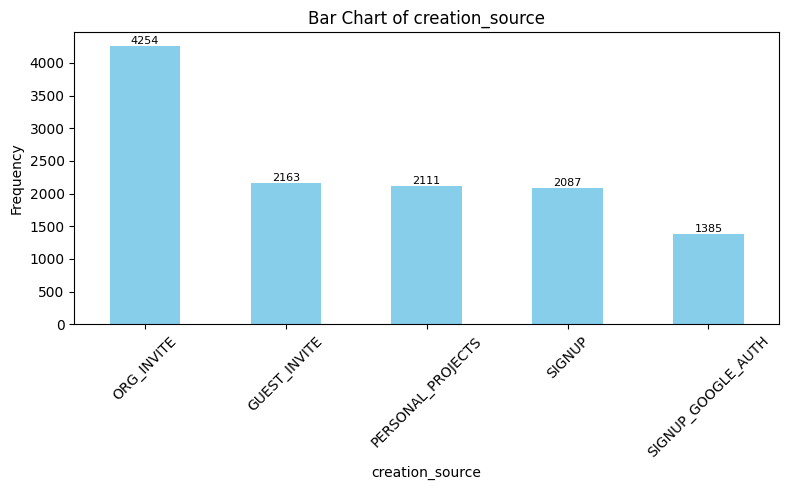

In [ ]:
# Categorical Columns
categorical_columns = ['creation_source']

# Value Counts and Bar Charts
for column in categorical_columns:
    value_counts = users[column].value_counts()

    plt.figure(figsize=(8, 5))
    bars = value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Bar Chart of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    # Add count labels on top of each bar
    for i, count in enumerate(value_counts):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


**Observations:**

1. **Most Popular Way to Sign Up**: ORG_INVITE is the most popular way to onboard the users, as it has the highest bar on the chart.
2. **Variety in Sign-Up Methods**: Excluding ORG_INVITE, it appears that other onboarding methods have relatively similar popularity among themselves.

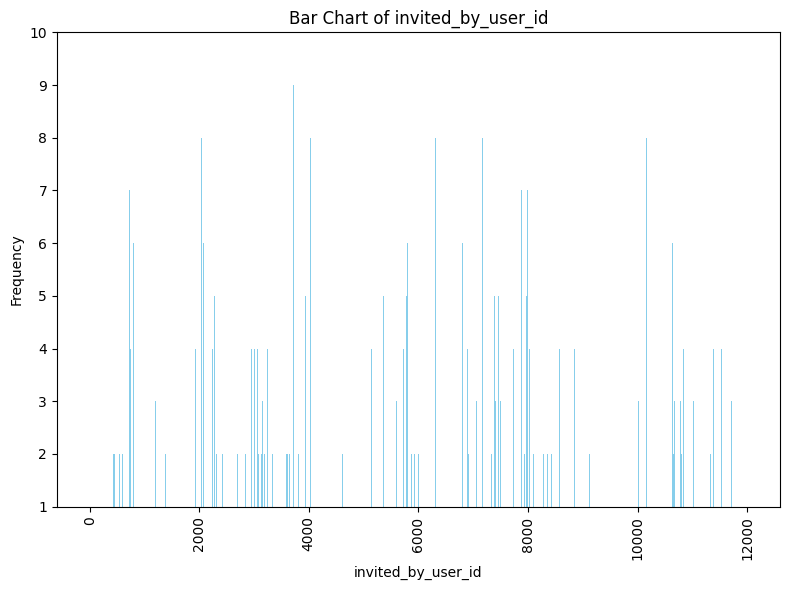

User ID 10741 has invited the maximum number of users: 13


In [ ]:
# Categorical Columns
categorical_columns = ['invited_by_user_id']

# Value Counts and Bar Charts
for column in categorical_columns:
    value_counts = users[column].value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(value_counts.index, value_counts.values, color='skyblue')
    plt.title('Bar Chart of invited_by_user_id')
    plt.xlabel('invited_by_user_id')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotating labels for readability
    plt.ylim(1, 10)  # Scaling the y-axis from 1 to 10
    plt.tight_layout()
    plt.show()

    # Find user ID with the maximum count
    max_user_id = value_counts.idxmax()
    max_count = value_counts.max()
    print(f"User ID {int(max_user_id)} has invited the maximum number of users: {max_count}")

## **5. Creating Target Variable : Define Adopted Users**

**Defination:**
*`Adopted user` is defined as a user who has logged into the application on three separate days in at least one seven ­day period.*

**Approach:**
We can define a method to segment login timestamps into seven-day periods for each user and determine which users meet the criteria of logging in on three separate days within any seven-day window.

In [ ]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
#Define a function to count visits in a 7-day rolling window
def count_visits_7_days(x):
    return x.rolling('7D', on='time_stamp')['user_id'].count()

In [ ]:
grouped = engagement.groupby('user_id', as_index=False, group_keys=False)
#Apply the rolling count function to each group
visits_7_days = grouped.apply(count_visits_7_days)

#Assign the results to a new column 'visits_7_days' in the original DataFrame
engagement['visits_7_days'] = visits_7_days


In [ ]:
adopted_users = engagement[engagement['visits_7_days']>=3]
adopted_users = adopted_users.drop_duplicates('user_id', keep = 'first')
adopted_users_list = list(adopted_users.user_id)
len(adopted_users_list)

1602

In [ ]:
engagement

,time_stamp,user_id,visited,visits_7_days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,1.0
207913,2013-01-15 18:28:37,11997,1,1.0
207914,2014-04-27 12:45:16,11998,1,1.0
207915,2012-06-02 11:55:59,11999,1,1.0


In [ ]:
users['adopted_user'] = 0
# Mark users in adopted_users_list as adopted users (adopted_user = 1)
users.loc[users['object_id'].isin(adopted_users_list), 'adopted_user'] = 1


In [ ]:
#Storing resultant dataframe
engagement.to_excel('/content/drive/MyDrive/TensorIOT Assignment/engagement_processed.xlsx', index=False)
users.to_excel('/content/drive/MyDrive/TensorIOT Assignment/users_processed.xlsx', index=False)

In [ ]:
users.adopted_user.value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

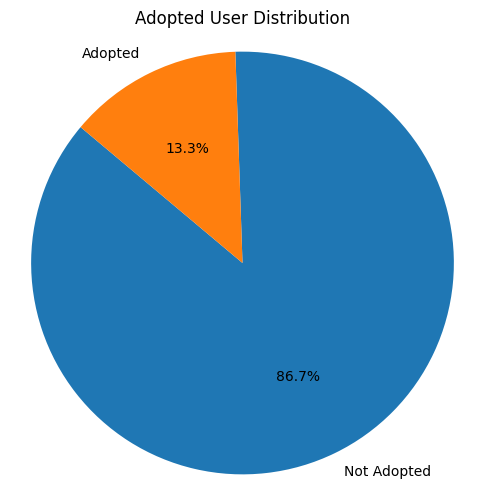

In [ ]:
# Calculate the counts of each category in 'adopted_user' column
adopted_counts = users['adopted_user'].value_counts()

# Create labels for the pie chart
labels = ['Not Adopted', 'Adopted']

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(adopted_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Adopted User Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


**Observations:**

Out of the total users in the dataset, only 13.3% were identified as adopted users. This suggests that there's a relatively lower proportion of users who met the criteria of being considered adopted users, which might indicate that the criteria for user adoption (logging in on three separate days within a seven-day period) is relatively stringent or that user engagement might be relatively lower overall within the analyzed dataset. Further investigation into user behavior or engagement patterns could provide insights into improving adoption rates or understanding why a smaller percentage of users met the adoption criteria.

##**6. Data Merging**

Combining the information from the two datasets files based on a common column, i.e. **`user_id`** or **`object_id`**

Here we will use **inner join** to retain only the rows from both dataframes maching on feature **object_id / user_id**. This gives us the dataframe that contains information about the users who have engagement data available.

In [ ]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [ ]:
engagement.head()

,time_stamp,user_id,visited,visits_7_days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [ ]:
# Merge user data with engagement data based on user_id/object_id
merged_data_processed = pd.merge(users, engagement, left_on='object_id', right_on='user_id', how='inner')
merged_data_processed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   object_id                   207917 non-null  int64         
 1   creation_time               207917 non-null  object        
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  float64       
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          116887 non-null  float64       
 10  adopted_user                207917 non-null  int64         
 11  time_stamp                  207917 non-

In [ ]:
invited_by_user_id_missingCount = len(merged_data_processed) - len([x for x in list(merged_data_processed.invited_by_user_id) if not isinstance(x, float) or not math.isnan(x)])
print(f"Missing Values Count from Feature invited_by_user_id :{invited_by_user_id_missingCount}")

Missing Values Count from Feature invited_by_user_id :91030


**Observations:**
1. As we can observed, the feature **`invited_by_user_id`** contains around 91030 NULL values, lets replace thise by 0 as 0 does not belongs to any user_id, indicating that users have onboarded without anyones invitation.

In [ ]:
merged_data_processed['invited_by_user_id'].fillna(0, inplace=True)
merged_data_processed['invited_by_user_id'] = merged_data_processed['invited_by_user_id'].astype('Int64')
merged_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   object_id                   207917 non-null  int64         
 1   creation_time               207917 non-null  datetime64[ns]
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          207917 non-null  Int64         
 10  adopted_user                207917 non-null  int64         
 11  time_stamp                  207917 non-

In [ ]:
len(list(set(list(merged_data_processed[merged_data_processed.adopted_user==1].object_id))))

1602

In [ ]:
# merged_data_processed.to_excel('/content/drive/MyDrive/TensorIOT Assignment/merged_data_processed_v2.xlsx', index=False)

## **7. Feature Engineering**

In [ ]:
merged_data_processed = pd.read_excel('/content/drive/MyDrive/TensorIOT Assignment/merged_data_processed.xlsx')
merged_data_processed.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,time_stamp,user_id,visited,visits_7_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,2014-04-22 03:53:30,1,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2013-11-15 03:45:04,2,1,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2013-11-29 03:45:04,2,1,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2013-12-09 03:45:04,2,1,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2013-12-25 03:45:04,2,1,1


In [ ]:
merged_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   object_id                   207917 non-null  int64         
 1   creation_time               207917 non-null  datetime64[ns]
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          116887 non-null  float64       
 10  adopted_user                207917 non-null  int64         
 11  time_stamp                  207917 non-

**Lets design few features based on available features**.

##### **7.1 Email Domain Analysis**

Examining email domains may reveals how users from different providers engage with the platform, potentially indicating which providers yield more active or loyal users. This information helps understand user demographics and their interaction patterns.

In [ ]:
#Email Domain Analysis
merged_data_processed['email_domain'] = merged_data_processed['email'].apply(lambda x: x.split('@')[-1])
email_domain_counts = merged_data_processed['email_domain'].value_counts().to_dict()
merged_data_processed['email_domain_frequency'] = merged_data_processed['email_domain'].map(email_domain_counts)

In [ ]:
#Email Provider Category
popular_domains = ['gmail.com', 'yahoo.com', 'hotmail.com']
merged_data_processed['email_category'] = merged_data_processed['email_domain'].apply(lambda x: 'popular' if x in popular_domains else 'other')


#### **7.2 Frequency of User Activity**
The 'activity_frequency' feature quantifies the time gaps between consecutive user actions within a platform. For each user, it measures the frequency of their engagement by computing the time intervals between successive activities, offering insight into the regularity or spacing of their interactions with the platform.

In [ ]:
#Frequency of User Activity
merged_data_processed['time_stamp'] = pd.to_datetime(merged_data_processed['time_stamp'])
activity_frequency = merged_data_processed.groupby('user_id')['time_stamp'].diff().fillna(pd.Timedelta(0))
merged_data_processed['activity_frequency'] = activity_frequency.dt.days


#### **7.3 Unique Interaction Days:**
The 'unique_interaction_days' feature counts the number of days each user has interacted with the platform, offering a metric to measure a user's consistent engagement over time. This information helps distinguish users who frequently engage across various days from those who might have sporadic interactions, aiding in assessing user retention or loyalty.

In [ ]:
from datetime import timedelta

# Calculate 'unique_interaction_days'
merged_data_processed['date'] = merged_data_processed['time_stamp'].dt.date
unique_days = merged_data_processed.groupby('user_id')['date'].nunique().reset_index()
unique_days.columns = ['user_id', 'unique_interaction_days']
merged_data_processed = pd.merge(merged_data_processed, unique_days, on='user_id', how='left')

#### **7.4 User Engagement Level:**
This feature can be calculated by dividing the number of visits in the last 7 days by unique_interaction_days. This will give us an idea of how engaged the user is on the platform.

In [ ]:
merged_data_processed['engagement_level'] = merged_data_processed['visits_7_days'] / merged_data_processed['unique_interaction_days']

#### **7.5 Temporal Patterns**
Identifying patterns in user activity based on time of day, day of the week, or month.

In [ ]:
# Feature 7: Temporal Patterns
merged_data_processed['day_of_week'] = merged_data_processed['time_stamp'].dt.dayofweek
merged_data_processed['hour_of_day'] = merged_data_processed['time_stamp'].dt.hour

#### **7.6 User Tenure:**
This feature can be calculated by subtracting the user's last_session_creation_time and creation_time.

In [ ]:
# merged_data_processed['creation_time'] = pd.to_datetime(merged_data_processed['creation_time'], unit='s', origin='unix')
# merged_data_processed['last_session_creation_time'] = pd.to_datetime(merged_data_processed['last_session_creation_time'], unit='s', origin='unix')

# Calculate the difference in days and create a new column 'days_between'
merged_data_processed['user_tenure'] = (merged_data_processed['last_session_creation_time'] - merged_data_processed['creation_time']).dt.days


#### **7.7 Social Network Influence**
Calculating the influence of the user who invited (invited_by_user_id) based on the number or type of users they have invited.

In [ ]:
#Social Network Influence
invited_users_count = merged_data_processed.groupby('invited_by_user_id')['user_id'].count().fillna(0).astype(int)
merged_data_processed['social_network_influence'] = invited_users_count
merged_data_processed['social_network_influence'] = merged_data_processed['social_network_influence'].fillna(0).astype(int)

In [ ]:
merged_data_processed.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,email_domain_frequency,email_category,activity_frequency,date,unique_interaction_days,engagement_level,day_of_week,hour_of_day,user_tenure,social_network_influence
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,...,31411,popular,0,2014-04-22,1,1.000000,1,3,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,19509,other,0,2013-11-15,14,0.071429,4,3,136,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,19509,other,14,2013-11-29,14,0.071429,4,3,136,0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,19509,other,10,2013-12-09,14,0.071429,0,3,136,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,...,19509,other,16,2013-12-25,14,0.071429,2,3,136,0


In [ ]:
merged_data_processed.to_excel("/content/drive/MyDrive/TensorIOT Assignment/Output/merged_data_extended.xlsx", index=False)

## **8. Bi-Variate Analysis**

#### **8.1 adopted_user vs user_tenure**

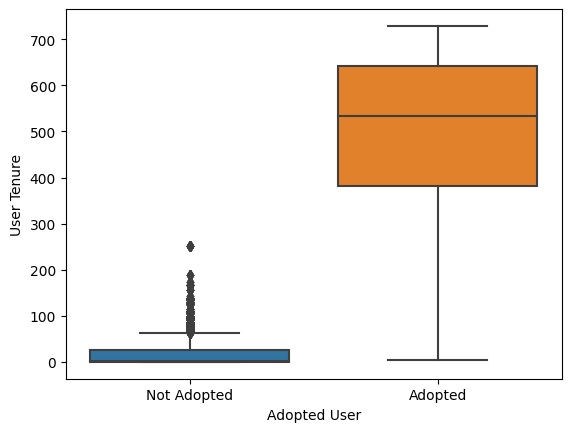

In [ ]:
# Plotting the boxplot
sns.boxplot(x='adopted_user', y='user_tenure', data=merged_data_processed)
plt.xlabel('Adopted User')
plt.ylabel('User Tenure')
plt.xticks([0, 1], ['Not Adopted', 'Adopted'])  # If 'adopted_user' is binary (0 or 1)
plt.show()


**Observation:**
1. It can be observed that adopted_user have longer tenure with the application.

#### **8.2 adopted_user vs org_id**

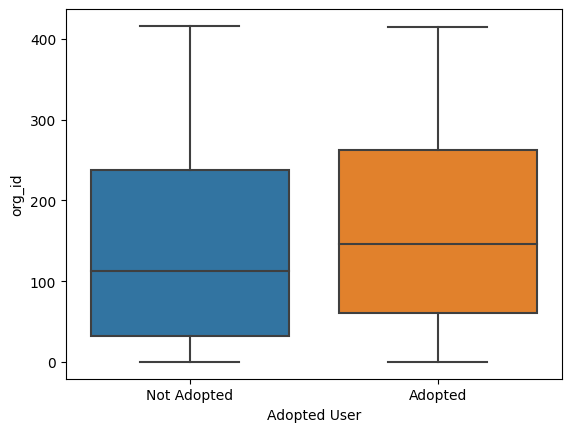

In [ ]:
# Plotting the boxplot
sns.boxplot(x='adopted_user', y='org_id', data=merged_data_processed)
plt.xlabel('Adopted User')
plt.ylabel('org_id')
plt.xticks([0, 1], ['Not Adopted', 'Adopted'])  # If 'adopted_user' is binary (0 or 1)
plt.show()


**Observation:**
1. An analysis of user adoption based on organization affiliation (org_id) reveals no clear distinction between adopted and non-adopted users.

##<font color='black'>**9. Data Encoding and Standardization:**</font>

In [ ]:
merged_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   object_id                   207917 non-null  int64         
 1   creation_time               207917 non-null  datetime64[ns]
 2   name                        207917 non-null  object        
 3   email                       207917 non-null  object        
 4   creation_source             207917 non-null  object        
 5   last_session_creation_time  207917 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    207917 non-null  int64         
 7   enabled_for_marketing_drip  207917 non-null  int64         
 8   org_id                      207917 non-null  int64         
 9   invited_by_user_id          116887 non-null  float64       
 10  adopted_user                207917 non-null  int64         
 11  time_stamp                  207917 non-

In [ ]:
numerical_features = ['org_id', 'invited_by_user_id', 'visits_7_days', 'email_domain_frequency', 'unique_interaction_days', 'engagement_level', 'days_between', 'social_network_influence']
categorical_features = ['creation_source', 'email_domain', 'email_category']
unwanted_features = ['creation_time', 'name', 'email', 'last_session_creation_time', 'visited', 'time_stamp', 'user_id', 'date', 'visits_7_days', 'engagement_level']
binary_features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']
target_variable = "adopted_user"

In [ ]:
merged_data_filtered = merged_data_processed.drop(columns=unwanted_features, errors='ignore')
merged_data_filtered

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,email_domain_frequency,email_category,activity_frequency,unique_interaction_days,day_of_week,hour_of_day,user_tenure,social_network_influence
0,1,GUEST_INVITE,1,0,11,10803.0,0,yahoo.com,31411,popular,0,1,1,3,0,0
1,2,ORG_INVITE,0,0,1,316.0,1,gustr.com,19509,other,0,14,4,3,136,0
2,2,ORG_INVITE,0,0,1,316.0,1,gustr.com,19509,other,14,14,4,3,136,0
3,2,ORG_INVITE,0,0,1,316.0,1,gustr.com,19509,other,10,14,0,3,136,1
4,2,ORG_INVITE,0,0,1,316.0,1,gustr.com,19509,other,16,14,2,3,136,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207912,11996,ORG_INVITE,0,0,89,8263.0,0,gustr.com,19509,other,0,1,4,6,0,0
207913,11997,SIGNUP_GOOGLE_AUTH,0,0,200,NaN,0,gmail.com,71310,popular,0,1,1,18,5,0
207914,11998,GUEST_INVITE,1,1,83,8074.0,0,cuvox.de,16503,other,0,1,6,12,0,0
207915,11999,PERSONAL_PROJECTS,0,0,6,NaN,0,iuxiw.com,1,other,0,1,5,11,2,0


**Handling Categorical Features:** - Not required if we use Decision Tree Based Approach. Lets handle this if we required to build non tree based algorithms.

**Handling Categorical Features:**

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for features in categorical_features:
  merged_data_filtered[features] = encoder.fit_transform(merged_data_filtered[features])

In [ ]:
merged_data_filtered

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,email_domain_frequency,email_category,activity_frequency,unique_interaction_days,day_of_week,hour_of_day,user_tenure,social_network_influence
0,1,0,1,0,11,10803.0,0,762,31411,1,0,1,1,3,0,0
1,2,1,0,0,1,316.0,1,213,19509,0,0,14,4,3,136,0
2,2,1,0,0,1,316.0,1,213,19509,0,14,14,4,3,136,0
3,2,1,0,0,1,316.0,1,213,19509,0,10,14,0,3,136,1
4,2,1,0,0,1,316.0,1,213,19509,0,16,14,2,3,136,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207912,11996,1,0,0,89,8263.0,0,213,19509,0,0,1,4,6,0,0
207913,11997,4,0,0,200,NaN,0,204,71310,1,0,1,1,18,5,0
207914,11998,0,1,1,83,8074.0,0,91,16503,0,0,1,6,12,0,0
207915,11999,2,0,0,6,NaN,0,281,1,0,0,1,5,11,2,0


In [ ]:
merged_data_filtered['invited_by_user_id'].fillna(0, inplace=True)
merged_data_filtered['invited_by_user_id'] = merged_data_filtered['invited_by_user_id'].astype('Int64')
merged_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   object_id                   207917 non-null  int64
 1   creation_source             207917 non-null  int64
 2   opted_in_to_mailing_list    207917 non-null  int64
 3   enabled_for_marketing_drip  207917 non-null  int64
 4   org_id                      207917 non-null  int64
 5   invited_by_user_id          207917 non-null  Int64
 6   adopted_user                207917 non-null  int64
 7   email_domain                207917 non-null  int64
 8   email_domain_frequency      207917 non-null  int64
 9   email_category              207917 non-null  int64
 10  activity_frequency          207917 non-null  int64
 11  unique_interaction_days     207917 non-null  int64
 12  day_of_week                 207917 non-null  int64
 13  hour_of_day                 207917 non-null 

In [ ]:
merged_data_filtered.to_excel('/content/drive/MyDrive/TensorIOT Assignment/merged_data_filtered_processed_V2.xlsx', index=False)

##<font color='black'>**10. Feature Selection**</font>

#### **10.1 Multivariate Analysis: Using Feature Correlation Matrix**

In [ ]:
merged_data_filtered = pd.read_excel('/content/drive/MyDrive/TensorIOT Assignment/merged_data_filtered_processed_V2.xlsx')

merged_data_filtered_x = merged_data_filtered.drop('adopted_user', axis=1)
merged_data_filtered_y = merged_data_filtered['adopted_user']

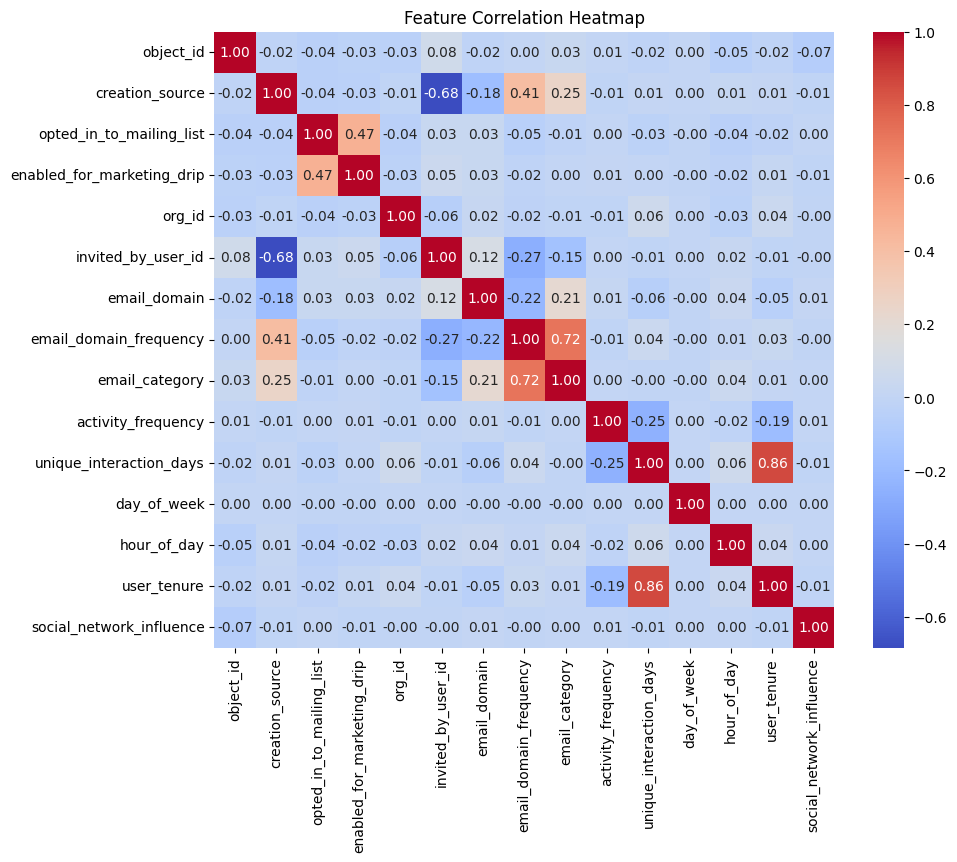

In [ ]:
# Assuming merged_data_filtered is your DataFrame
correlation_matrix = merged_data_filtered_x.corr()

# Increase figure size
plt.figure(figsize=(10, 8))

# Plotting the correlation matrix as a heatmap with limited decimal points
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


**Observations:**
1. The features **`unique_interaction_days`** and **`user_tenure`** looks like highly correlated, we can discart one of them to avoid overfitting and Multicollinearity issues.

In [ ]:
high_corr_features = ['unique_interaction_days']
merged_data_filtered_x.drop(high_corr_features, axis=1, inplace=True)

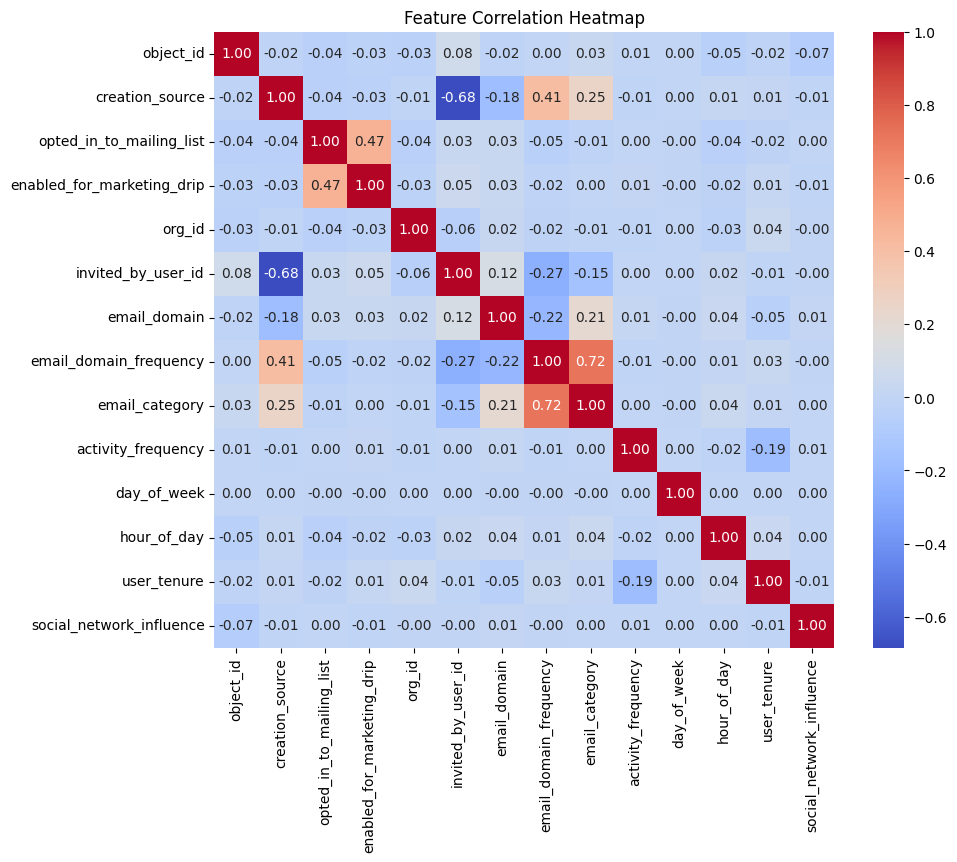

In [ ]:
# Assuming merged_data_filtered is your DataFrame
correlation_matrix = merged_data_filtered_x.corr()

# Increase figure size
plt.figure(figsize=(10, 8))

# Plotting the correlation matrix as a heatmap with limited decimal points
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
merged_data_filtered_x.to_excel('/content/drive/MyDrive/TensorIOT Assignment/final_training_X.xlsx', index=False)
y_train = pd.DataFrame(merged_data_filtered['adopted_user'])
y_train.to_excel('/content/drive/MyDrive/TensorIOT Assignment/final_training_y.xlsx', index=False)

##<font color='black'>**11. Modelling and Feature Importance**</font>


Reading Training Data

In [ ]:
features = pd.read_excel('/content/drive/MyDrive/TensorIOT Assignment/final_training_X.xlsx')
labels = pd.read_excel('/content/drive/MyDrive/TensorIOT Assignment/final_training_y.xlsx')

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=27)

#### **11.1 Computing Feature Importance with RandomForestClassifier**

With the RandomForestClassifier in scikit-learn, we leverage the feature_importances_ attribute, which automatically ranks features by their contribution to the model's performance during training. By analyzing these importance scores, we're able to identify and select the most influential features. This process enables us to streamline our model by choosing the top-ranked features based on a set threshold or a specific number, ultimately enhancing efficiency without sacrificing performance.

Train Loss: 0.0025165116852340365
Test Loss: 0.00842435871545733
Plotting Feature Importance



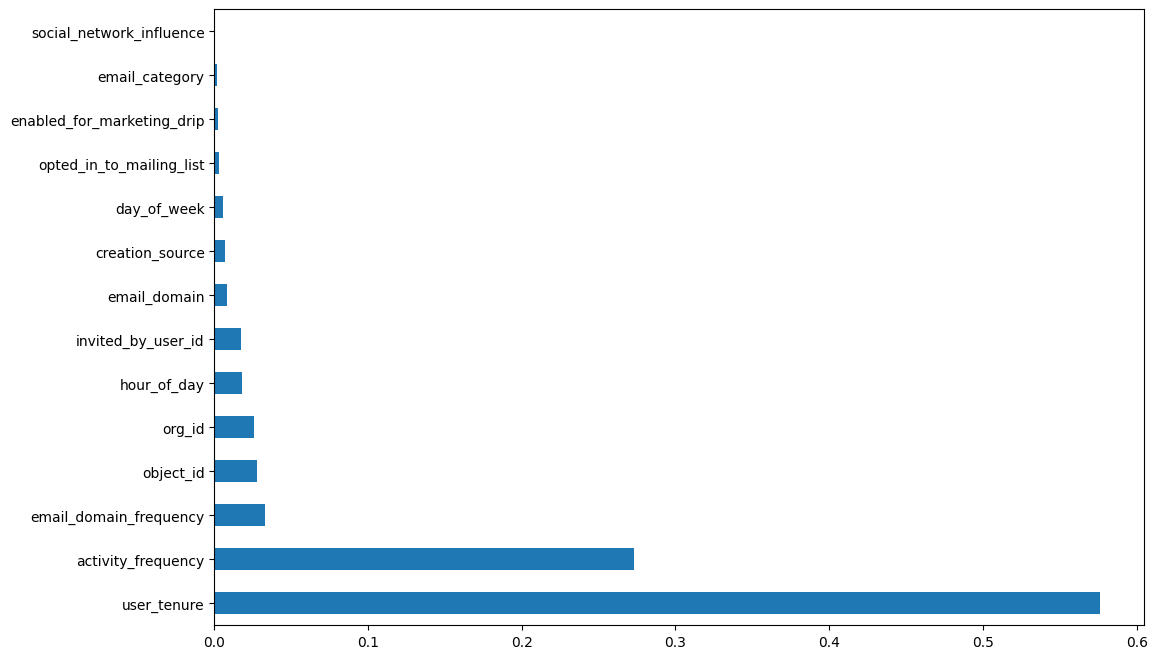

RandomForestClassifier model saved successfully!



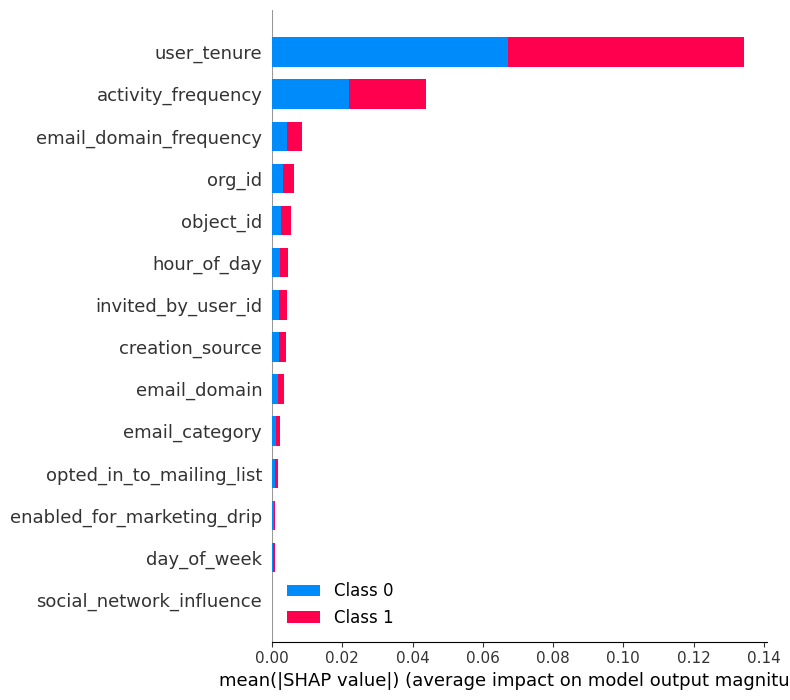

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss


# Train the RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Get predicted probabilities for train and test sets
train_probs = rf_classifier.predict_proba(X_train)
test_probs = rf_classifier.predict_proba(X_test)

# Convert y_train and y_test to 1-dimensional arrays using ravel()
y_train_1d = y_train.values.ravel()
y_test_1d = y_test.values.ravel()

# Calculate train and test losses using log loss
train_loss = log_loss(y_train_1d, train_probs)
test_loss = log_loss(y_test_1d, test_probs)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Plot feature importance
print("Plotting Feature Importance\n")
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

# Save the trained RandomForestClassifier model
model_filename = '/content/drive/MyDrive/TensorIOT Assignment/Output/random_forest_model.pkl'
joblib.dump(rf_classifier, model_filename)
print("RandomForestClassifier model saved successfully!\n")

# SHAP values computation and summary plot
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_train[:5000])
np.save('/content/drive/MyDrive/TensorIOT Assignment/Output/rf_shap_values', shap_values)

shap.summary_plot(shap_values, X_train[:5000], plot_type="bar")


#### **11.2 Computing Feature Importance with XGBClassifier**

Train Loss: 0.2363896225962073
Test Loss: 0.2352648270425857
Model saved successfully!

Computing Shap Values:



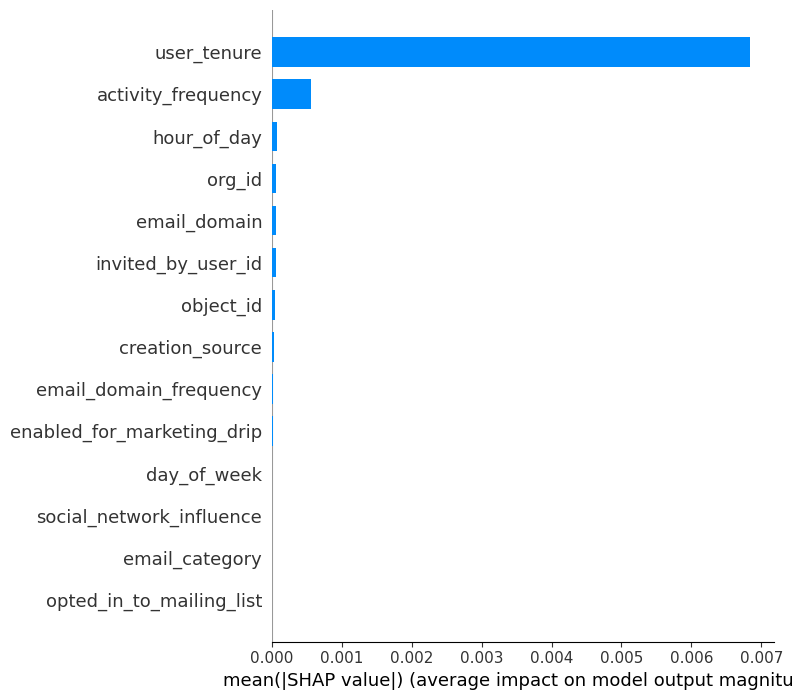

In [ ]:
from xgboost import XGBClassifier


# Selecting fewer datapoints as this algorithm runs very slow on larger datasets.
datapoints = 50000

# XGBClassifier for classification
xgb_classifier = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.001, random_state=0, num_parallel_tree=5)
xgb_classifier.fit(X_train[:datapoints], y_train[:datapoints])

# Get predicted probabilities for train and test sets
train_probs = xgb_classifier.predict_proba(X_train[:datapoints])
test_probs = xgb_classifier.predict_proba(X_test[:datapoints])  # Assuming X_test and y_test are defined

# Convert y_train and y_test to 1-dimensional arrays using ravel()
y_train_1d = y_train[:datapoints].values.ravel()
y_test_1d = y_test[:datapoints].values.ravel()

# Calculate train and test losses using log loss
train_loss = log_loss(y_train_1d, train_probs)
test_loss = log_loss(y_test_1d, test_probs)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

model_filename = '/content/drive/MyDrive/TensorIOT Assignment/Output/xgboost_model.pkl'
joblib.dump(xgb_classifier, model_filename)
print("Model saved successfully!")

# Computing Shap Values
print("\nComputing Shap Values:\n")
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_train[:datapoints])
np.save('/content/drive/MyDrive/TensorIOT Assignment/Output/XGBoost_shap_values', shap_values)
shap.summary_plot(shap_values, X_train[:datapoints], plot_type="bar")

**Observation:**
Based on the results shown by Random Forest Classifier and XGBoost, below featurs seems to be contributing singnificantly to the user_adoption.
1. `user_tenure`
2. `activity_frequency`
3. `email_domain_frequency`
4. `org_id`

However,
* There is no clear distinction between adopted and non-adopted users with respect to `email_domain_frequency` and `org_id`.
* More **hyperparameter finetuning** and **complex feature engineering** is needed.

## **12. Conclusion**

When we looked at what makes users stick around, we found that how long someone has been using the app really matters—they're more likely to keep using it if they've been around for a while. Other important things include how often they use the app, their email type, and how much they interact with it. Interestingly, where they fit in the organization (org_id) doesn't seem to play a big role by itself in whether they become a regular user."

Additionaly, it is important to note that only 13.3% of all users fit the 'adopted user' definition, which might mean it's hard to meet the criteria—logging in three times in a week—or that users aren't very active. Looking closer at how users behave could help us make it easier for more users to meet this criteria or understand why only a small group does.

## **Future Work:**

* Designing complex features aims to uncover undiscovered relationships between the target variable (i.e., adopted_user) and other independent variables.
* Experimenting with hyperparameter fine-tuning and various machine learning algorithms helps identify significant features.

`END`